# Introduction
In the previous posts, we calculated accessibility in terms of distance. Distance is an excellent metric for driving or walking on flat land. For short travels by car or walking on flat land, distance can be directly converted to travel time; most people have an intuitive understanding of their average driving speeds (50 km/h for residential roads in New Zealand) or their approximate walking speed on flat land (usually around 5 km / h for a fit adult as given in [Section 3.4 in NZTA pedestrian planning and design guide](https://www.nzta.govt.nz/assets/resources/pedestrian-planning-guide/docs/pedestrian-planning-guide.pdf)). Hills are not an issue for drivers provided road quality and safety are no different to flat land. But hills do impact travel time significantly for pedestrians; which in turn impacts accessibility. 

> _This post will consider the impact of hills on pedestrian accessibility to playgrounds in Wellington._

Playgrounds are key amenities that impact the quality of life for young families. Since they are also frequently accessed on foot, it's important to consider how accessible they really are. Particularly for suburbs with a high residential fraction.   

## Tasks
- Calculate the impact of walking in hilly terrain on travel time to council playgrounds in Wellington
- Compare the travel times to playground for the largest residential suburbs in Wellington
- Model the average travel time to a playground by suburb 


## Technical details
To do this analysis, we need to overcome some technical aspects:
- Re-do accessibility analysis: from distance to travel time
- Get elevation data for roads and walkways
- Convert elevation to road / walkway inclination 
- Incorporate inclination in the accessibility analysis
    - Include road inclines in the pandana network
    - Estimate the impact of inclination on travel time
    


In [4]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.data_processing as dp
import utils.accessibility_analysis as aa
import geopandas 
import numpy as np
import seaborn as sns
import folium
import yaml
from importlib import reload

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
%matplotlib inline

## Set bounding box

A bounding box of lattitude and longitude coordinates describes a rectangular geospatial region. For this report, I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection is important since only the entities *within* the bounding box are used in the analysis. The visual tool [here](http://boundingbox.klokantech.com/) is useful for obtaining the bounding box coordinates from a user-defined rectangle on the map. 

A key technical point is that [bounding box conventions do vary](https://wiki.openstreetmap.org/wiki/Bounding_Box
):
- The general definition uses (min Longitude , min Latitude , max Longitude , max Latitude), or  (W, S, E, N) 
- Pandana and Overpass use (S, W, N, E).

![](assets/wellington-city-bounding-box.png)


In [56]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.38,174.84,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

# Load datasets

There are 3 key datasets used in this analysis:
- *WCC playground locations*: downloaded as a zip file
- *Suburb boundaries for Wellington*
    - StatsNZ 2013 Statistical Area 2 boundaries: downloaded as a geodatabase (gdb)
    - StatsNZ 2013 meshblocks: downloaded  as a geodatabase (gdb). Used for easy filtering of the Statistical Area 2 boundaries 
- *Wellington street network*
    - without elevation: using OpenStreetMap via *pandana*
    - with elevation: using OpenStreetMap and Google Elevation API via *osmnx*



## WCC Playgrounds

In [58]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds = wcc_playgrounds.to_crs(epsg=4167)

In [59]:
map_playground = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in wcc_playgrounds.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_playground)

map_playground

## Suburb boundaries

In [57]:
# Get LINZ data
nz_area_unit = geopandas.read_file('../spatial-plays/data/area-unit-2013/area-unit-2013.gdb/')
nz_mesh = geopandas.read_file('../spatial-plays/data/meshblock-2013/meshblock-2013.gdb/')

# Spatial area units in SA2 data
wlg_mesh = nz_mesh.query('TLAName == "Wellington City"')
wlg_area_units = nz_area_unit[nz_area_unit['AU2013_V1_00_NAME'].isin(wlg_mesh['AreaUnitName'].unique())]
wlg_area_units = wlg_area_units.to_crs(epsg=4167)

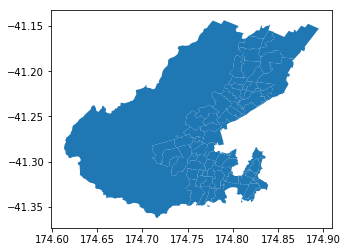

In [258]:
wlg_area_units.plot()

## Wellington street network: without elevation
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

In [ ]:
flat_network = aa.get_pandana_network(osm_bbox, impedance=distance)

The _pandana_ network above has edge weights in the default units of metres, which means that the accessibility analyses will also be in metres. We can post-hoc convert the distance units to travel time with an average walking speed of 5 km/h or, 83 m/minute if we want travel time in minutes. 

## Wellington street network: with elevation
Elevation information can be retrieved with the Google Elevation API to enrich both the nodes and edges of the network. For the nodes, we can just get the elevation at a single location. Elevation at the connecting nodes of an edge can be used to derive the _inclination_. 

The above steps have been simplified to terse oneliners by the excellent Python package, _osmnx_. The steps to generate a _pandana_ network for accessibility analyses enriched with road inclinations are given below. They're mostly borrowed from [Geoff Boeing's tutorial](https://geoffboeing.com/2017/05/osmnx-street-network-elevation/). 
- [Signing up to the Google Elevation API](https://developers.google.com/maps/documentation/elevation/start) and getting an API key. 
- Storing the API key in an YAML file (to stop commits that contain keys! - something I've been guilty of many times over)
- Creating an _osmnx_ graph
- Retrieving elevation data from Google Elevation API
- Adding elevation information to nodes 
- Adding inclination (grade) to edges
- Converting edge weights to travel time
- Creating a _pandana_ network from an _osmnx_ graph


In [9]:
with open("utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.load(stream)

In [61]:
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

In [62]:
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)

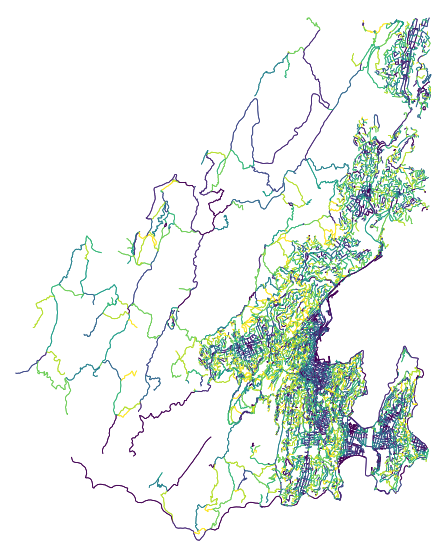

In [186]:
edge_grades = [data['grade'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]
ec = ox.get_edge_colors_by_attr(G, 'grade_abs', cmap='viridis', num_bins=10)
fig, ax = ox.plot_graph(G, fig_height=10, edge_color=ec, edge_linewidth=0.8, node_size=0)


(-0.5, 0.5)

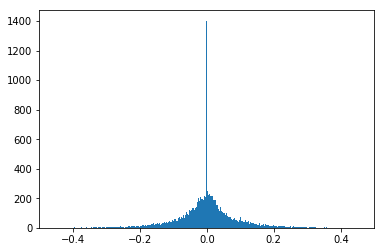

In [188]:
plt.hist(edge_grades, bins=1000);
plt.xlim(-0.5,0.5)

# Accessibility by street grade

## Define new impedance function

In [115]:
def toblers_function(grade):
    W = 6*np.exp(-3.5*(grade + 0.05))
    return W

def toblers_time_minutes(grade, distance):
    W = 6*np.exp(-3.5*(grade + 0.05))
    time_hr = (distance / 1000) / W
    time_mins = time_hr * 60.0
    return time_mins

def brunsdon_toblers_time_minutes(grade, distance):
    W = 3.57*np.exp(-2.03* np.abs(grade + 0.133))
    time_hr = (distance / 1000) / W
    time_mins = time_hr * 60.0
    return time_mins

def flat_travel_time(distance, speed=5.0):
    time_hr = (distance / 1000) / speed
    time_mins = time_hr * 60.0
    return time_mins
    

In [129]:
def hiking_time(grade, distance, params_list=[6.0, 3.5, 0.05]):
    W = params_list[0]*np.exp(- params_list[1]* np.abs(grade + params_list[2]))
    time_hr = (distance / 1000) / W
    time_mins = time_hr * 60.0
    return time_mins

street_grades = np.arange(-0.4, 0.4, 0.001)
test_df = pd.DataFrame({'grade':street_grades})
test_df['distance'] = 100

test_df['toblers'] = hiking_time(test_df['grade'], test_df['distance'])
test_df['brunsdon'] = hiking_time(test_df['grade'], test_df['distance'], params_list=[3.557, 2.03, 0.13])
test_df['flat_5khr'] = flat_travel_time(test_df['distance'])
test_df['flat_3khr'] = flat_travel_time(test_df['distance'], 3.0)

,grade,distance,toblers,brunsdon,flat_5khr,flat_3khr
0,-0.400,100,3.404166,2.918127,1.2,2.0
1,-0.399,100,3.392272,2.912209,1.2,2.0
2,-0.398,100,3.380420,2.906303,1.2,2.0
3,-0.397,100,3.368609,2.900410,1.2,2.0
4,-0.396,100,3.356840,2.894528,1.2,2.0


In [226]:
print(hiking_time(-0.12, 100, params_list=[3.557, 2.03, 0.13]))
print(hiking_time(0, 100))

1.7214069941114682
1.191246216612358


In [233]:
(100 / 1.7) * (1/60)

0.9803921568627452

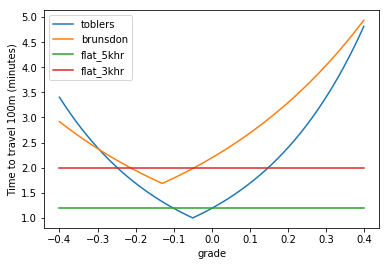

In [185]:
test_df[['toblers', 'brunsdon', 'flat_5khr', 'flat_3khr', 'grade']].plot(x='grade')
plt.ylabel('Time to travel 100m (minutes)');

In [234]:
data = ox.get_undirected(G).edges(keys=True, data=True)
data_df = pd.DataFrame([data for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)])
data_df['time_weight'] = toblers_time_minutes(data_df['grade'], data_df['length'])
data_df.head()

,access,bridge,from,geometry,grade,grade_abs,highway,junction,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,time_weight
0,NaN,NaN,1259072929,"LINESTRING (174.7934694 -41.2275193, 174.79300...",0.1319,0.1319,residential,NaN,NaN,NaN,66.800,50,Truscott Avenue,False,110175609,NaN,NaN,1259077823,NaN,NaN,1.262612
1,NaN,NaN,1259072943,"LINESTRING (174.7921165 -41.2280406, 174.79263...",-0.0475,0.0475,residential,NaN,NaN,NaN,65.443,50,Truscott Avenue,False,110175609,NaN,NaN,1259077823,NaN,NaN,0.660181
2,NaN,NaN,6083853567,"LINESTRING (174.7919818 -41.2292681, 174.79198...",-0.1116,0.1116,residential,NaN,NaN,NaN,177.292,50,John Sims Drive,False,110176112,NaN,NaN,1259077823,NaN,NaN,1.429076
3,NaN,NaN,6083853567,"LINESTRING (174.7919818 -41.2292681, 174.79198...",0.1650,0.1650,residential,NaN,NaN,NaN,13.022,50,John Sims Drive,False,110176112,NaN,NaN,1259077824,NaN,NaN,0.276366
4,NaN,NaN,465611807,"LINESTRING (174.8062183 -41.213616, 174.806057...",0.0396,0.0396,residential,NaN,NaN,NaN,71.272,50,Cambrian Street,False,107284021,NaN,NaN,1259077827,NaN,NaN,0.975245


In [204]:
data_df[data_df['name'] == "Mamaku Way"]

,access,bridge,from,geometry,grade,grade_abs,highway,junction,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,time_weight
10703,NaN,NaN,307349953,"LINESTRING (174.7643307 -41.2846013, 174.76440...",0.0260,0.0260,footway,NaN,NaN,NaN,48.607,NaN,Mamaku Way,False,27989246,NaN,NaN,307349889,NaN,NaN,1.128130
10708,NaN,NaN,714230406,"LINESTRING (174.7648578 -41.2821784, 174.76484...",-0.1119,0.1119,footway,NaN,NaN,NaN,8.560,NaN,Mamaku Way,False,27989246,NaN,NaN,307349931,NaN,NaN,0.150162
10711,NaN,NaN,307349950,"LINESTRING (174.7644042 -41.2842239, 174.76438...",0.0148,0.0148,footway,NaN,NaN,NaN,154.231,NaN,Mamaku Way,False,27989246,NaN,NaN,307349935,NaN,NaN,3.499112
10712,NaN,NaN,307350057,"LINESTRING (174.764869 -41.2822448, 174.764888...",0.0764,0.0764,footway,NaN,NaN,NaN,74.876,NaN,Mamaku Way,False,27989246,NaN,NaN,307349935,NaN,NaN,1.925025
10713,NaN,NaN,307349953,"LINESTRING (174.7643307 -41.2846013, 174.76432...",0.0133,0.0133,footway,NaN,NaN,NaN,42.711,NaN,Mamaku Way,False,27989246,NaN,NaN,307349950,NaN,NaN,0.966059
10739,NaN,NaN,714230406,"LINESTRING (174.7648578 -41.2821784, 174.76486...",0.1252,0.1252,footway,NaN,NaN,NaN,7.442,NaN,Mamaku Way,False,27989246,NaN,NaN,307350057,NaN,NaN,0.211255


In [205]:
node_data = ox.get_undirected(G).nodes(data=True)
node_dict = dict(node_data)
node_df = pd.DataFrame.from_dict(node_dict).transpose()
node_df.index.name = 'id'
node_df.head()

,elevation,highway,osmid,x,y
id,,,,,
1259077823,196.755,NaN,1.25908e+09,174.793,-41.2279
1259077824,218.696,NaN,1.25908e+09,174.792,-41.2294
1259077827,163.804,NaN,1.25908e+09,174.805,-41.2137
3619684648,12.692,NaN,3.61968e+09,174.781,-41.2766
3619684652,12.344,NaN,3.61968e+09,174.781,-41.276


# New approach to load pandana network with elevation

In [235]:
# Transform network edge weights to travel times
data_df['distance'] = flat_travel_time(data_df['length'], 6.0)
new_data_df = data_df[['from', 'to', 'grade', 'distance', 'length']]
new_data_df['from_idx'] = new_data_df['from']
new_data_df['to_idx'] = new_data_df['to']
new_data_df= new_data_df.set_index(['from_idx', 'to_idx'])
new_data_df.index.names= ['','']

# Speed penalty for hilly areas
hill_data_df = new_data_df.copy()
hill_data_df['distance'] = toblers_time_minutes(hill_data_df['grade'], hill_data_df['length'])

In [236]:
flat_data_df = data_df.copy()
flat_data_df['distance']= flat_data_df['length']

In [237]:
hill_data_df.head()

from          to   grade  distance   length
                                                                        
1259072929 1259077823  1259072929  1259077823  0.1319  1.262612   66.800
1259072943 1259077823  1259072943  1259077823 -0.0475  0.660181   65.443
6083853567 1259077823  6083853567  1259077823 -0.1116  1.429076  177.292
           1259077824  6083853567  1259077824  0.1650  0.276366   13.022
465611807  1259077827   465611807  1259077827  0.0396  0.975245   71.272

In [238]:
new_data_df.head()

from          to   grade  distance   length
                                                                        
1259072929 1259077823  1259072929  1259077823  0.1319   0.66800   66.800
1259072943 1259077823  1259072943  1259077823 -0.0475   0.65443   65.443
6083853567 1259077823  6083853567  1259077823 -0.1116   1.77292  177.292
           1259077824  6083853567  1259077824  0.1650   0.13022   13.022
465611807  1259077827   465611807  1259077827  0.0396   0.71272   71.272

In [239]:
network_trial = pa.Network(
        node_df['x'], node_df['y'],
        new_data_df['from'], new_data_df['to'], new_data_df[['distance']])

network_hills_trial = pa.Network(
        node_df['x'], node_df['y'],
        hill_data_df['from'], hill_data_df['to'], hill_data_df[['distance']])


In [240]:
flat_distance_network = pa.Network(
        node_df['x'], node_df['y'],
        flat_data_df['from'], flat_data_df['to'], flat_data_df[['distance']])

In [241]:
playground_accessibility = aa.get_accessibility(network_trial, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_accessibility = aa.get_accessibility(network_hills_trial, wcc_playgrounds, distance=30, num_pois=10)

In [242]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
#plot_kwargs = {'s':5, 
#               'alpha':0.9, 
#               'cmap':'viridis_r', 
#               'edgecolor':'none'}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

Text(0.5, 1.0, 'Walking time (mins) to nearest Council Playground in Wellington: flat ground assumption')

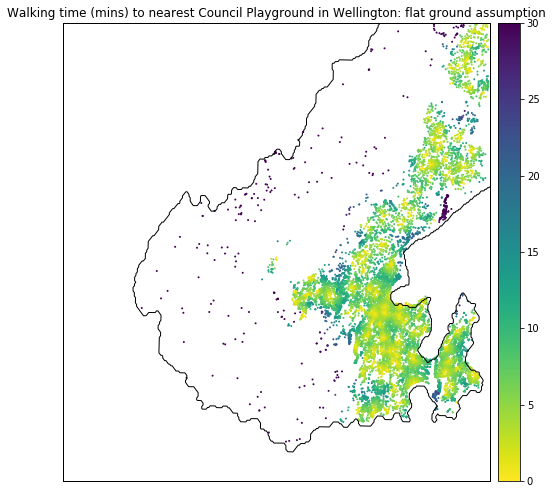

In [243]:
aa.plot_accessibility(network_trial, playground_accessibility[1], osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)
plt.title('Walking time (mins) to nearest Council Playground in Wellington: flat ground assumption')

In [244]:
playground_accessibility_flat = aa.get_accessibility(flat_distance_network, wcc_playgrounds, distance=2500, num_pois=10)

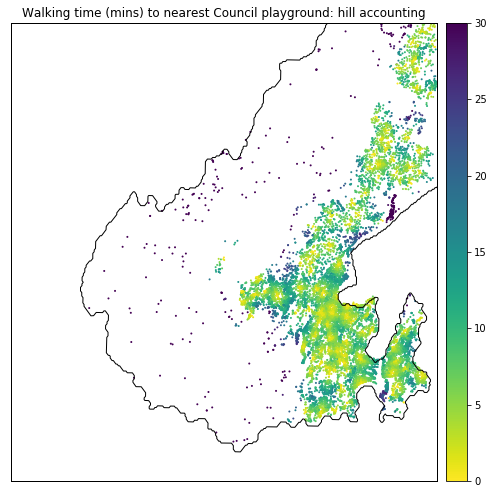

In [245]:
aa.plot_accessibility(network_hills_trial, playground_hills_accessibility[1], osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)
plt.title('Walking time (mins) to nearest Council playground: hill accounting');

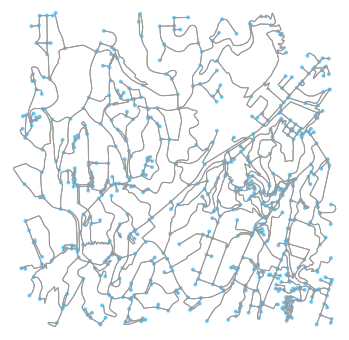

(<Figure size 590.571x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a34a45da0>)

In [80]:
G_sub = ox.graph_from_point((-41.2825478, 174.7615090), distance=900, network_type='walk')
ox.plot_graph(G_sub)

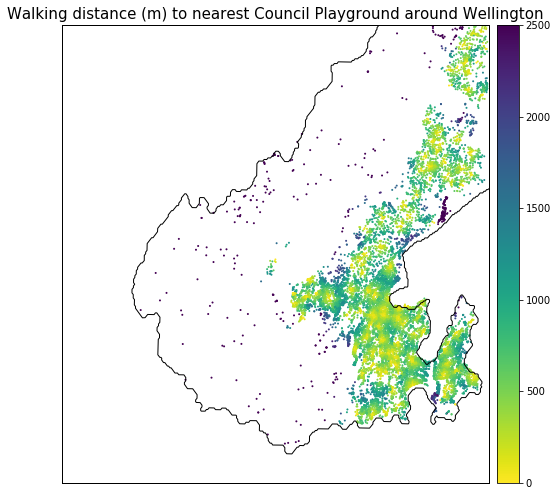

In [81]:
aa.plot_accessibility(flat_distance_network, playground_accessibility_flat[1], osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)
#plt.title('Walking time (mins) to nearest Council Playground in Wellington: flat ground assumption')

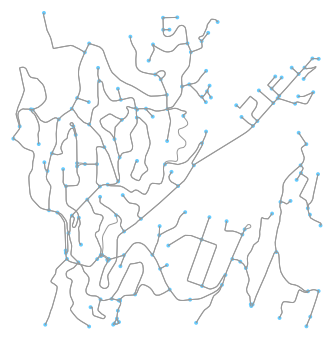

(<Figure size 564.007x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a34ca2470>)

In [82]:
G_sub = ox.graph_from_point((-41.2825478, 174.7615090), distance=900, network_type='drive')
ox.plot_graph(G_sub)

In [83]:
nodes, _ = ox.graph_to_gdfs(G_sub)
nodes.head()

,highway,osmid,x,y,geometry
172750848,NaN,172750848,174.755,-41.2871,POINT (174.7547651 -41.2871303)
293312520,NaN,293312520,174.758,-41.2898,POINT (174.7582548 -41.2897992)
172750856,traffic_signals,172750856,174.755,-41.2867,POINT (174.7546752 -41.2866998)
193611282,NaN,193611282,174.772,-41.2828,POINT (174.7719767 -41.2827637)
170453015,NaN,170453015,174.769,-41.2868,POINT (174.7691202 -41.2867792)


In [84]:
playground_accessibility.ix[293316873]

1      8.147000
2     10.549000
3     15.226000
4     16.799000
5     19.371000
6     19.839001
7     21.566999
8     26.125000
9     26.561001
10    27.214001
Name: 293316873, dtype: float64

In [85]:
playground_accessibility_flat.ix[293316873]

1      679.301025
2      879.872009
3     1269.344971
4     1400.964966
5     1615.219971
6     1653.744019
7     1797.833984
8     2177.781006
9     2214.316895
10    2269.541992
Name: 293316873, dtype: float64

In [86]:
playground_hills_accessibility.ix[293316873]

1     13.939000
2     20.830999
3     30.000000
4     30.000000
5     30.000000
6     30.000000
7     30.000000
8     30.000000
9     30.000000
10    30.000000
Name: 293316873, dtype: float64

In [87]:
(679/6.75) * (60/1000)

6.035555555555556

In [88]:
hill_data_df[hill_data_df['from'] == 293316873]

from          to   grade  distance   length
                                                                      
293316873 1690451735  293316873  1690451735  0.1035  5.378453  198.003
          1690451768  293316873  1690451768 -0.0621  4.196387  216.215
          293316869   293316873   293316869  0.0213  0.049656    2.160

# Validating pandana with Graphhopper Routing API

Visualised [here](https://www.openstreetmap.org/directions?engine=graphhopper_foot&route=-41.28228%2C174.76145%3B-41.28352%2C174.76559#map=17/-41.28247/174.76603)

In [10]:
graph_hopper_api_key = data_loaded['graph_hopper_api_key'][0]
graph_hopper_query = "https://graphhopper.com/api/1/route?point=-41.28228,174.76145&point=-41.28352,174.76559&vehicle=foot&points_encoded=false&locale=nz&key=" + graph_hopper_api_key

In [12]:
%%bash -s "$graph_hopper_query"
curl $1

{"hints":{"visited_nodes.average":"38.0","visited_nodes.sum":"38"},"info":{"copyrights":["GraphHopper","OpenStreetMap contributors"],"took":12},"paths":[{"distance":714.815,"weight":423.840217,"time":514662,"transfers":0,"points_encoded":false,"bbox":[174.761453,-41.283523,174.765629,-41.282102],"points":{"type":"LineString","coordinates":[[174.761453,-41.282274],[174.761556,-41.28231],[174.761589,-41.282407],[174.761905,-41.282449],[174.761958,-41.282571],[174.761933,-41.282646],[174.761754,-41.282885],[174.761788,-41.283035],[174.761917,-41.28316],[174.76219,-41.283275],[174.762386,-41.283379],[174.762797,-41.28334],[174.76299,-41.283305],[174.763289,-41.283009],[174.763493,-41.282658],[174.763737,-41.282442],[174.764054,-41.282246],[174.764241,-41.282201],[174.764536,-41.282165],[174.764845,-41.282102],[174.764858,-41.282178],[174.764869,-41.282245],[174.765038,-41.282236],[174.765055,-41.282515],[174.765029,-41.282649],[174.764967,-41.282802],[174.765087,-41.282817],[174.765072,-41

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2697  100  2697    0     0   1164      0  0:00:02  0:00:02 --:--:--  1164


In [90]:
route = [[174.761453,-41.282274],[174.761556,-41.28231],[174.761589,-41.282407],[174.761905,-41.282449],[174.761958,-41.282571],[174.761933,-41.282646],[174.761754,-41.282885],[174.761788,-41.283035],[174.761917,-41.28316],[174.76219,-41.283275],[174.762386,-41.283379],[174.762797,-41.28334],[174.76299,-41.283305],[174.763289,-41.283009],[174.763493,-41.282658],[174.763737,-41.282442],[174.764054,-41.282246],[174.764241,-41.282201],[174.764536,-41.282165],[174.764845,-41.282102],[174.764858,-41.282178],[174.764869,-41.282245],[174.765038,-41.282236],[174.765055,-41.282515],[174.765029,-41.282649],[174.764967,-41.282802],[174.765087,-41.282817],[174.765072,-41.282912],[174.765298,-41.282989],[174.765114,-41.283073],[174.765338,-41.283153],[174.765307,-41.28321],[174.765302,-41.283272],[174.765344,-41.283328],[174.765628,-41.283451],[174.765629,-41.283497],[174.765594,-41.283523]]

# Accessibility by Wellington suburb

In [217]:
playground_hills_accessibility.head()

,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
1259077823,17.139999,30.000,30.000,30.000000,30.000000,30.000,30.0,30.0,30.0,30.0
1259077824,20.650999,30.000,30.000,30.000000,30.000000,30.000,30.0,30.0,30.0,30.0
1259077827,10.315000,11.415,15.738,22.037001,24.629999,27.358,30.0,30.0,30.0,30.0
3619684648,18.871000,30.000,30.000,30.000000,30.000000,30.000,30.0,30.0,30.0,30.0
3619684652,17.534000,30.000,30.000,30.000000,30.000000,30.000,30.0,30.0,30.0,30.0


In [218]:
playground_accessibility.head()

,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
1259077823,12.608,22.959999,27.164000,30.000000,30.000,30.000,30.000,30.0,30.0,30.0
1259077824,15.817,26.169001,30.000000,30.000000,30.000,30.000,30.000,30.0,30.0,30.0
1259077827,7.859,8.340000,11.110000,18.684999,18.823,21.409,29.466,30.0,30.0,30.0
3619684648,14.571,24.375999,26.441999,30.000000,30.000,30.000,30.000,30.0,30.0,30.0
3619684652,13.345,25.468000,27.534000,30.000000,30.000,30.000,30.000,30.0,30.0,30.0


In [253]:
orig_nodes = network_trial.nodes_df 
def filtered_accessibility_network(pandana_network, filtered_accessibility):

    network_nodes = pandana_network.nodes_df.reset_index()
    new_network_nodes = []
    for node in filtered_accessibility.reset_index()['id'].tolist():
        val = network_nodes[network_nodes['id'] == node]
        new_network_nodes.append(val)
    
    new_network_nodes = pd.concat(new_network_nodes).set_index('id')
    pandana_network.nodes_df = new_network_nodes
    return pandana_network, filtered_accessibility


In [254]:
# Get filtered network for plotting
diff_accessibility = playground_hills_accessibility[1] - playground_accessibility[1]
network_access_1000, access_1000 = filtered_accessibility_network(network_trial, 
                                                                  diff_accessibility[diff_accessibility > 2])

ValueError: 'c' argument has 3142 elements, which is not acceptable for use with 'x' with size 178, 'y' with size 178.

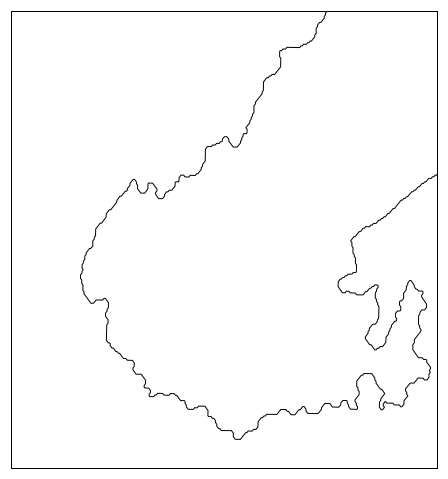

In [255]:
# Plotting parameters
diff_kwargs = plot_kwargs.copy()
# diff_kwargs['cmap'] = 'spectral_r'
bmap_kwargs={'epsg':'2193','resolution':'f'}
cbar_kwargs = {'location': 'right'}

bmap = aa.plot_accessibility(network_access_1000, access_1000, osm_bbox, 
                             amenity_type="",
                             place_name='Wellington', 
                             fig_kwargs=fig_kwargs, plot_kwargs=diff_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)

# Comparing accessibility by SA2 unit

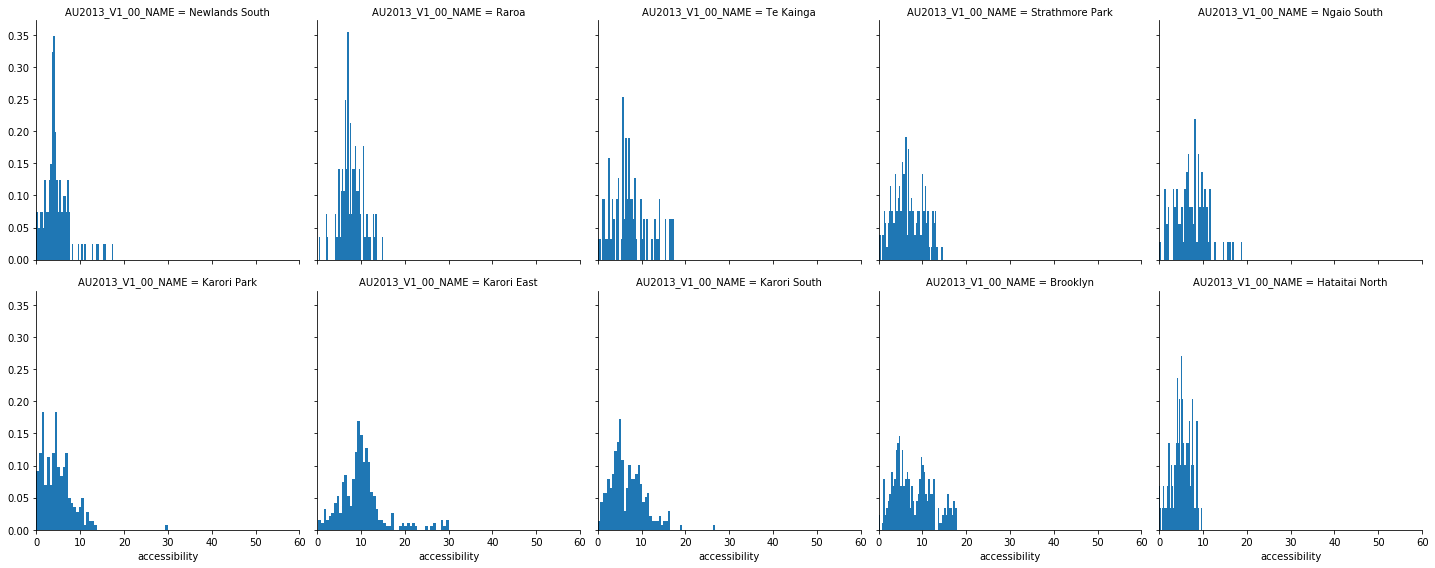

In [249]:
# Get lat and lon coordinates for accessibility values
orig_nodes = network.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), playground_accessibility[[1]].reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']
# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})


playground_df = geopandas.sjoin(wlg_area_units, df_joined_coords, op='contains')
df_sel = playground_df[playground_df['AU2013_V1_00_NAME'].isin(['Karori Park', 'Te Kainga',
                                          'Karori South', 'Karori East',
                                         'Newlands South', 'Hataitai North', 
                                          'Strathmore Park', 'Raroa',
                                         'Ngaio South', 'Brooklyn'])]
g = sns.FacetGrid(col='AU2013_V1_00_NAME', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
plt.xlim(0,60);

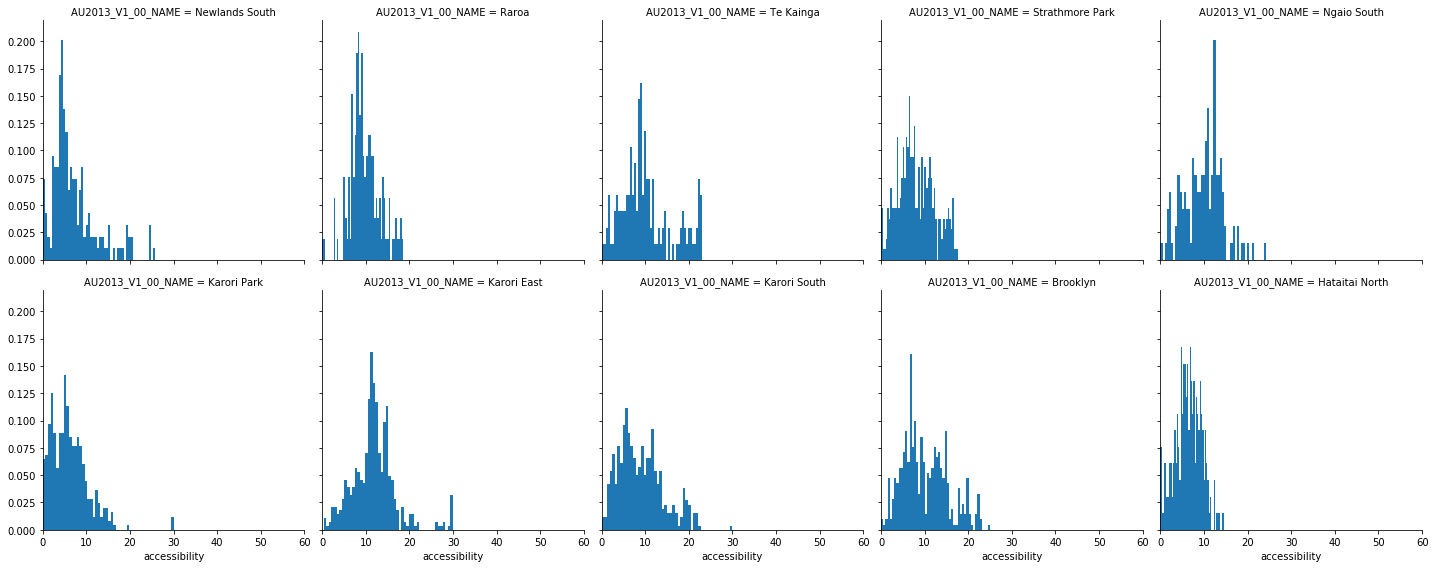

In [250]:
# Get lat and lon coordinates for accessibility values
orig_nodes = network_hills_trial.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), playground_hills_accessibility[[1]].reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']
# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})


playground_df = geopandas.sjoin(wlg_area_units, df_joined_coords, op='contains')
df_sel = playground_df[playground_df['AU2013_V1_00_NAME'].isin(['Karori Park', 'Te Kainga',
                                          'Karori South', 'Karori East',
                                         'Newlands South', 'Hataitai North', 
                                          'Strathmore Park', 'Raroa',
                                         'Ngaio South', 'Brooklyn'])]
g = sns.FacetGrid(col='AU2013_V1_00_NAME', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
plt.xlim(0,60);
#plt.ylim(0, 0.0035);